## Modelling the sea using grid-based methods

In [ ]:
!pip install basemap
!pip install basemap-data-hires

In [38]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import math

In [19]:
base_lat = [33, 42]
base_lon = [122, 132]

# 탱커와 벌커의 평균 속도: 15~16노트(28~30km/h)
avg_speed = 30
pivot_time = 5
gridmap_pivot_distance_km = 5

earth_radius = 6371
lat_distance_per_one = round(earth_radius * math.pi / 180, 3)
lon_distance_per_one = {0:111.322, 5:110.902, 10:109.643, 15:117.553, 20:114.650, 25:100.953, 30:96.490, 
                        35:91.290, 40:85.397, 45:78.850, 50:71.700, 55:63.997, 60:55.803, 65:47.178, 70:38.188, 
                        75:28.904, 80:19.394, 85:9.735, 90:0}

absolute_distance_pos = [[0],[0]]

for lat in range(base_lat[0]+1, base_lat[1]+1):
    absolute_distance_pos[0].append(lat_distance_per_one)
    absolute_distance_pos[1].append(lon_distance_per_one[(lat//5)*5])

In [20]:
absolute_distance_pos

[[0,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195],
 [0, 96.49, 91.29, 91.29, 91.29, 91.29, 91.29, 85.397, 85.397, 85.397]]

In [43]:
grid_lat = [base_lat[0]]
grid_lon = [base_lon[0]]

for ilat in range(1, len(absolute_distance_pos[0])):
    vlat = lat_distance_per_one # this is never changed. so not need
    while(True):
        tlat = 0
        if(vlat > gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km
        else: tlat = vlat # vlat <= gridmap_pivot_distance_km

        vlat -= tlat
        dlat = tlat/lat_distance_per_one

        grid_lon.append(grid_lon[-1] + dlat)

        if(vlat <= 0):
            break


print(grid_lon)            
collection_grid_lon = [(grid_lon[i]-base_lon[0])*(base_lon[1]-grid_lon[-1])/grid_lon[-1] for i in range(0, len(grid_lon))]
print(collection_grid_lon)
grid_lon = [x+y for x,y in zip(grid_lon, collection_grid_lon)]

# for ilon in range(1, len(absolute_distance_pos[1])):
#     vlon = absolute_distance_pos[1][ilon]
#     while(True):
#         tlon = 0
#         if(tlon != gridmap_pivot_distance_km):
#             tlon = gridmap_pivot_distance_km - tlon
#         elif(vlon > gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km
#         else: tlon = vlon # vlon <= gridmap_pivot_distance_km
            
#         vlon -= tlon
#         dlon = tlon/lon_distance_per_one[(ilon//5)*5]
            
#         grid_lat.append(grid_lat[-1] + dlon)
            
#         if(vlon <= 0):
#             break
# # grid_lat = [x / grid_lat[-1] * base_lat[1] for x in grid_lat]
        
# print('Grid_latitude_steps')
# print(grid_lat)
# print()
# print('Grid_longitude_steps')
# print(grid_lon)

[122, 122.04496605063177, 122.08993210126354, 122.13489815189531, 122.17986420252709, 122.22483025315886, 122.26979630379063, 122.3147623544224, 122.35972840505417, 122.40469445568594, 122.44966050631771, 122.49462655694948, 122.53959260758126, 122.58455865821303, 122.6295247088448, 122.67449075947657, 122.71945681010834, 122.76442286074011, 122.80938891137188, 122.85435496200365, 122.89932101263543, 122.9442870632672, 122.98925311389897, 122.99999999999996, 123.04496605063173, 123.0899321012635, 123.13489815189527, 123.17986420252704, 123.22483025315881, 123.26979630379059, 123.31476235442236, 123.35972840505413, 123.4046944556859, 123.44966050631767, 123.49462655694944, 123.53959260758121, 123.58455865821298, 123.62952470884476, 123.67449075947653, 123.7194568101083, 123.76442286074007, 123.80938891137184, 123.85435496200361, 123.89932101263538, 123.94428706326715, 123.98925311389893, 123.99999999999991, 124.04496605063169, 124.08993210126346, 124.13489815189523, 124.179864202527, 12

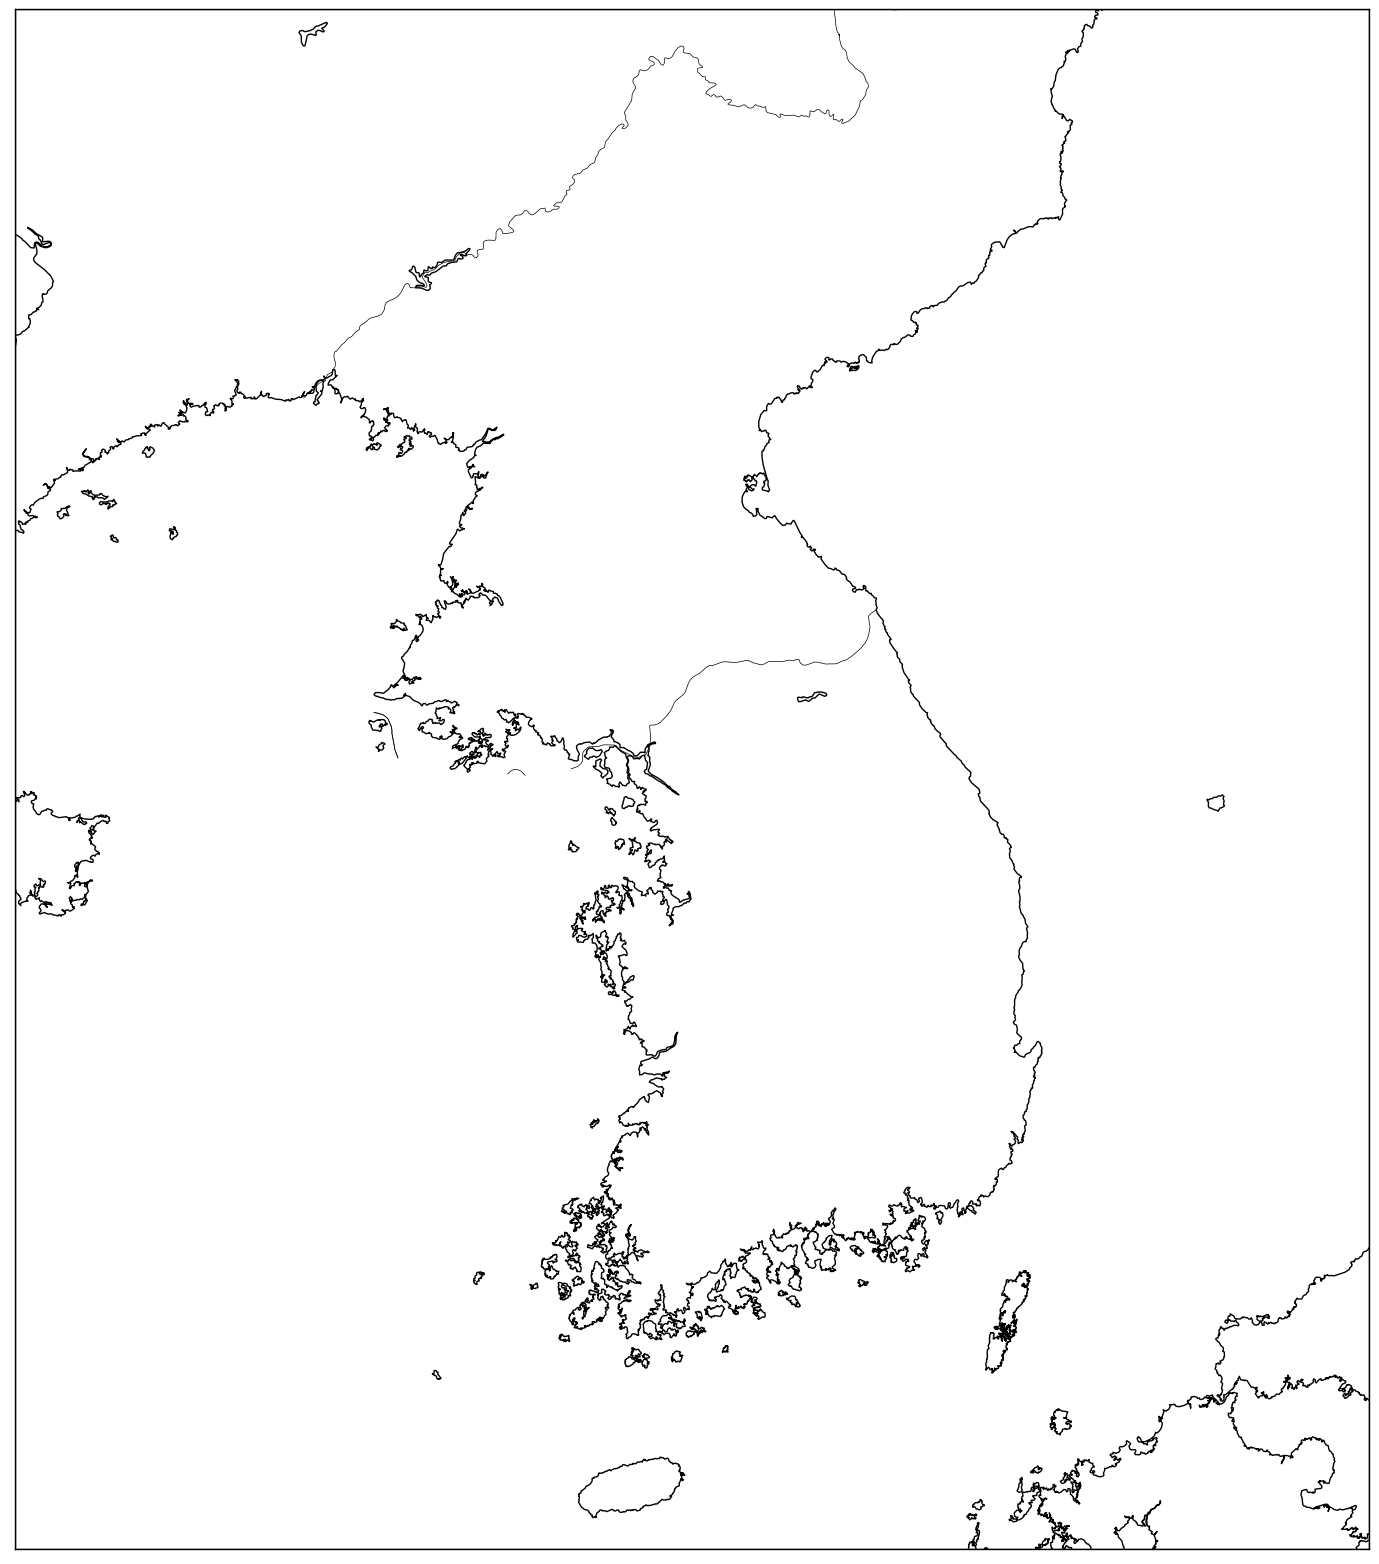

In [31]:
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

# m.drawmeridians(np.arange(base_lon[0], base_lon[1], 0.5))
# m.drawparallels(np.arange(base_lat[0], base_lat[1], 0.5))
 

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup lambert conformal basemap.
# lat_1 is first standard parallel.
# lat_2 is second standard parallel (defaults to lat_1).
# lon_0,lat_0 is central point.
# rsphere=(6378137.00,6356752.3142) specifies WGS84 ellipsoid
# area_thresh=1000 means don't plot coastline features less
# than 1000 km^2 in area.

f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)

m = Basemap(width=12000000,height=9000000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)


m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='aqua')
# draw tissot's indicatrix to show distortion.
ax = plt.gca()
for y in np.linspace(m.ymax/20,19*m.ymax/20,9):
    for x in np.linspace(m.xmax/20,19*m.xmax/20,12):
        lon, lat = m(x,y,inverse=True)
        poly = m.tissot(lon,lat,1.5,100,\
                        facecolor='green',zorder=10,alpha=0.5)
plt.show()

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup lambert conformal basemap.
# lat_1 is first standard parallel.
# lat_2 is second standard parallel (defaults to lat_1).
# lon_0,lat_0 is central point.
# rsphere=(6378137.00,6356752.3142) specifies WGS84 ellipsoid
# area_thresh=1000 means don't plot coastline features less
# than 1000 km^2 in area.

# m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
#             urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
#             resolution='h', projection='merc',)

m = Basemap(rsphere=(6378137.00,6356752.3142),
            resolution='h',area_thresh=1000.,projection='merc',
            lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)




m.drawcountries()
m.drawmapboundary()
m.shadedrelief()
m.drawcoastlines()
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
# draw tissot's indicatrix to show distortion.
ax = plt.gca()
for y in np.linspace(m.ymax/20,19*m.ymax/20,9):
    for x in np.linspace(m.xmax/20,19*m.xmax/20,12):
        lon, lat = m(x,y,inverse=True)
        poly = m.tissot(lon,lat,1.5,100,\
                        facecolor='green',zorder=10,alpha=0.5)
plt.show()

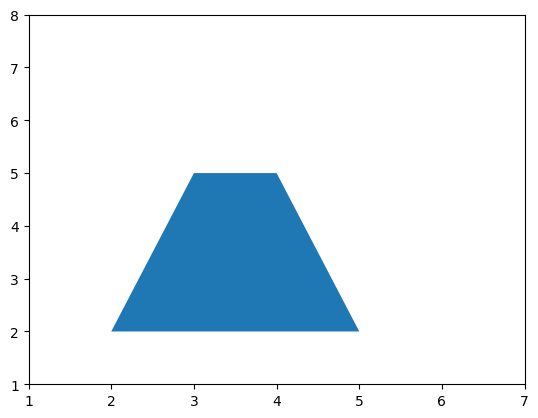

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
pts = np.array([[2,2], [5,2], [4,5], [3, 5]])
p = Polygon(pts, closed=False)
ax = plt.gca()
ax.add_patch(p)
ax.set_xlim(1,7)
ax.set_ylim(1,8)
plt.show()